<a href="https://colab.research.google.com/github/edsonportosilva/OptiCommPy/blob/main/examples/test_fec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
if 'google.colab' in str(get_ipython()):
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install .

Cloning into 'OptiCommPy'...
remote: Enumerating objects: 11273, done.
remote: Counting objects: 100% (2074/2074), done.
remote: Compressing objects: 100% (368/368), done.
remote: Total 11273 (delta 1807), reused 1909 (delta 1705), pack-reused 9199 (from 1)
Receiving objects: 100% (11273/11273), 208.04 MiB | 26.01 MiB/s, done.
Resolving deltas: 100% (8419/8419), done.
Updating files: 100% (592/592), done.
Processing /content/OptiCommPy
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 749.5/749.5 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 8.1 MB/s eta 0:00:00
  Created wheel for OptiCommPy: filename=OptiCommPy-0.9.0-py3-none-any.whl size=89656 sha256=0325bf920ea542299cc4d02b574ef7d616

In [2]:
from optic.comm.modulation import modulateGray, demodulateGray, grayMapping
from optic.comm.metrics import calcLLR, fastBERcalc, monteCarloGMI
from optic.dsp.core import pnorm
from optic.comm.fec import encodeLDPC, decodeLDPC, plotBinaryMatrix
from optic.models.channels import awgn
from optic.plot import pconst
from optic.utils import parameters
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from pathlib import Path
import time
from scipy.sparse import csr_matrix

In [3]:
%load_ext autoreload
%autoreload 2

## Test LDPC encoder/decoder

Time for encoding per codeword: 25.06 ms


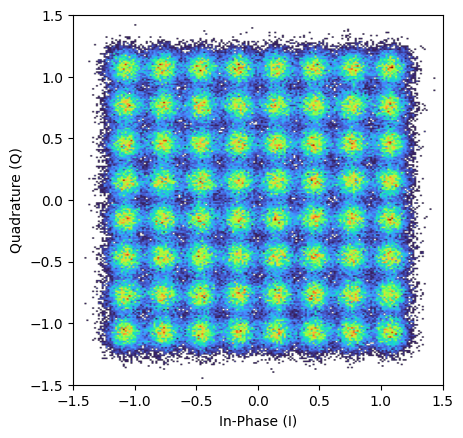

Time for decoding - total: 30.32 s, per codeword: 101.07 ms

----------------------Results-------------------------

LDPC AR4JA: k = 4096, n = 5120
Net rate = 4.80 bits/symbol
GMI = 5.61 bits/symbol
BERpreFEC = 1.72e-02
BERpostFEC = 0.00e+00
Total number of bits =  1689600


In [28]:
if 'google.colab' in str(get_ipython()):
    alistFolder = '/content/OptiCommPy/optic/comm/ALIST/'
else:
    # get the path of the current file and the repo path
    filePath = Path().resolve()
    repoPath = str(filePath.parent)
    alistFolder = repoPath + r'\optic\comm\ALIST\\' # change this to the path of the ALIST folder

# run AWGN simulation
EbN0dB = 11   # SNR per bit in dB
M      = 64   # modulation order
Nwords = 300  # number of codewords
nIter  = 50   # maximum number of decoding iterations

# modulation parameters
constSymb = grayMapping(M,'qam')             # constellation
bitMap = demodulateGray(constSymb, M, 'qam') # bit mapping
bitMap = bitMap.reshape(-1, int(np.log2(M)))

# encode data bits with LDPC
paramEnc = parameters()
paramEnc.mode = 'AR4JA' #'IEEE_802.11nD2', 'DVBS2'
paramEnc.n = 5120
paramEnc.R = '4/5'
paramEnc.path = alistFolder

k = (paramEnc.n*int(paramEnc.R[0]))//int(paramEnc.R[2])

# generate random bits
bits = np.random.randint(2, size = (k, Nwords), dtype=np.uint8)

# encode bits with LDPC code
start = time.time()
codedBits = encodeLDPC(bits, paramEnc)
end = time.time()
print(f'Time for encoding per codeword: {(end-start)/Nwords*1000:.2f} ms')

codedBitsTx = codedBits.copy().flatten()

# map coded bits to constellation symbols
symbTx = modulateGray(codedBitsTx, M, 'qam')

# normalize symbols energy to 1
symbTx = pnorm(symbTx)

# AWGN channel
snrdB  = EbN0dB + 10*np.log10(np.log2(M))
symbRx = awgn(symbTx, snrdB)

# pre-FEC BER calculation (hard demodulation)
BERpre, _, _ = fastBERcalc(symbRx, symbTx, M, 'qam')
GMI, NGMI = monteCarloGMI(symbRx, symbTx, M, 'qam')

pconst(symbRx, pType='fancy', R=1.5)

# soft-demodulation
noiseVar = 1/10**(snrdB/10)
px = np.ones(M)/M
llrs = calcLLR(pnorm(symbRx), noiseVar, pnorm(constSymb), bitMap, px)

# soft-decoding
paramDec = parameters()
paramDec.H = paramEnc.H
paramDec.alg = 'MSA'
paramDec.maxIter = nIter
paramDec.prgsBar = True
paramDec.prec = np.float16

start = time.time()
decodedBits, llr_dec, frameErrors = decodeLDPC(llrs.reshape(-1,codedBits.shape[1]).T, paramDec)
end = time.time()
print(f'Time for decoding - total: {end-start:.2f} s, per codeword: {(end-start)/Nwords*1000:.2f} ms\n')
decodedBits = (decodedBits.T).flatten()

# post-FEC BER calculation
BERpost = np.mean(np.logical_xor(codedBitsTx.flatten(), decodedBits.flatten()))
print('----------------------Results-------------------------\n')
print(f'LDPC {paramEnc.mode}: k = {k}, n = {int(paramEnc.n)}')
print(f'Net rate = {int(paramEnc.R[0])/int(paramEnc.R[2])*np.log2(M):.2f} bits/symbol')
print(f'GMI = {GMI[0]:.2f} bits/symbol')
print(f'BERpreFEC = {BERpre[0]:.2e}')
print(f'BERpostFEC = {BERpost:.2e}')
print(f'Total number of bits = ', decodedBits.size)

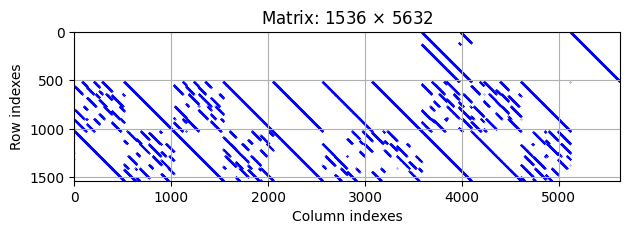

In [18]:
plotBinaryMatrix(csr_matrix.todense(paramEnc.H))

## Evaluate performance as a function of the received SNR

In [25]:
Nwords = 240  # number of codewords
M = 64 # modulation order

# Run BER vs Ebn0 Monte Carlo simulation
nIter_  = [10, 20, 50, 100, 200]  # max decoding iterations
EbN0dB_  = np.arange(9.5, 11.1, 0.1)

BERpre   = np.zeros((len(EbN0dB_),len(nIter_)))
BERpost  = np.zeros((len(EbN0dB_),len(nIter_)))

BERpre[:]  = np.nan
BERpost[:] = np.nan

for ii, nIter in enumerate(nIter_):
    print('run sim: M = ', M)

    # modulation parameters
    constSymb = grayMapping(M,'qam')             # constellation
    bitMap = demodulateGray(constSymb, M, 'qam') # bit mapping
    bitMap = bitMap.reshape(-1, int(np.log2(M)))

    for indSNR in tqdm(range(EbN0dB_.size)):

        EbN0dB = EbN0dB_[indSNR]

        # encode data bits with LDPC
        paramEnc = parameters()
        paramEnc.mode = 'AR4JA' #'IEEE_802.11nD2'
        paramEnc.n = 5120
        paramEnc.R = '4/5'
        paramEnc.path = alistFolder

        k = (paramEnc.n*int(paramEnc.R[0]))//int(paramEnc.R[2])

        # generate random bits
        bits = np.random.randint(2, size = (k, Nwords), dtype=np.uint8)

        # encode bits with LDPC code
        start = time.time()
        codedBits = encodeLDPC(bits, paramEnc)
        end = time.time()
        #print(f'Time for encoding per codeword: {(end-start)/Nwords*1000:.2f} ms')

        codedBitsTx = codedBits.copy().flatten()

        # map coded bits to constellation symbols
        symbTx = modulateGray(codedBitsTx, M, 'qam')

        # normalize symbols energy to 1
        symbTx = pnorm(symbTx)

        # AWGN  channel
        snrdB = EbN0dB + 10*np.log10(np.log2(M))
        symbRx = awgn(symbTx, snrdB)

        # pre-FEC BER calculation (hard demodulation)
        BERhd, _, _ = fastBERcalc(symbRx, symbTx, M, 'qam')
        BERpre[indSNR, ii] = BERhd[0]

        # soft-demodulation
        noiseVar = 1/10**(snrdB/10)
        px = np.ones(M)/M
        llr = calcLLR(pnorm(symbRx), noiseVar, pnorm(constSymb), bitMap, px)

        # soft-decoding
        paramDec = parameters()
        paramDec.H = paramEnc.H
        paramDec.alg = 'MSA'
        paramDec.maxIter = nIter
        paramDec.prgsBar = False
        paramDec.prec = np.float16

        start = time.time()
        decodedBits, llr_dec, _ = decodeLDPC(llr.reshape(-1,codedBits.shape[1]).T, paramDec)
        end = time.time()
        #print(f'Time for decoding per codeword: {(end-start)/Nwords*1000:.2f} ms')
        decodedBits = (decodedBits.T).flatten()

        # post-FEC BER calculation
        BERpost[indSNR, ii] = np.mean(np.logical_xor(codedBitsTx.flatten(), decodedBits.flatten()))

run sim: M =  64


100%|██████████| 16/16 [11:49<00:00, 44.36s/it]


run sim: M =  64


100%|██████████| 16/16 [15:30<00:00, 58.17s/it]


run sim: M =  64


100%|██████████| 16/16 [24:01<00:00, 90.12s/it]


run sim: M =  64


100%|██████████| 16/16 [37:46<00:00, 141.69s/it]


run sim: M =  64


100%|██████████| 16/16 [1:03:44<00:00, 239.01s/it]


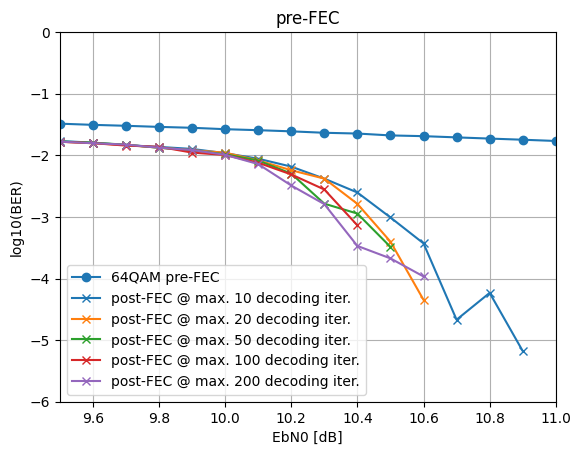

In [26]:
# Plot simulation results
BERpre[BERpre==0] = np.nan
BERpost[BERpost==0] = np.nan

#plt.figure(figsize=(10,6))
#for ii, nIter in enumerate(nIter_[0]):
plt.plot(EbN0dB_,np.log10(BERpre[:, 0]),'o-',label=f'{str(M)}QAM pre-FEC')
plt.gca().set_prop_cycle(None)
plt.title(f'{str(M)}QAM with LDPC {paramEnc.mode}: k = {k}, n = {int(paramEnc.n)}')

for ii, nIter in enumerate(nIter_):
    plt.plot(EbN0dB_, np.log10(BERpost[:, ii]),'x-', label=f'post-FEC @ max. {nIter} decoding iter.')

plt.xlim(min(EbN0dB_), max(EbN0dB_))
plt.ylim(-6, 0)
plt.legend();
plt.xlabel('EbN0 [dB]')
plt.ylabel('log10(BER)')
plt.grid();